Import necessary libs

In [74]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [75]:
client = MongoClient("mongodb://localhost:27017/")
db = client["PythonForDs"]
collection = db["isw_report"]
cursor = collection.find()
df = pd.DataFrame(list(cursor))

Check of dataset

In [76]:
df.head()

,_id,date,extracted_text
0,67f568f9dcd7a5c401c30a6b,2022-02-25,Russian forces entered major Ukrainian cities—...
1,67f568f9dcd7a5c401c30a6c,2022-02-26,Russian forces’ main axes of advance in the la...
2,67f568f9dcd7a5c401c30a6d,2022-02-27,The Russian military has likely recognized tha...
3,67f568f9dcd7a5c401c30a6e,2022-02-28,The Russian military is reorganizing its milit...
4,67f568f9dcd7a5c401c30a6f,2022-03-01,Russian forces are completing the reinforcemen...


Basic cleaning

In [77]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


df['cleaned_text'] = df['extracted_text'].apply(clean_text)

In [78]:
nltk.download('punkt_tab')
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [79]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['no_stopwords'] = df['tokens'].apply(
    lambda words: [word for word in words if word not in stop_words]
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We are trying to clean text and lemmatize, stemm it, but also then we will check if necessary too
clean it 1 more time

In [80]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['no_stopwords'].apply(
    lambda words: [lemmatizer.lemmatize(word) for word in words]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [81]:
stemmer = PorterStemmer()
df['stemmed'] = df['no_stopwords'].apply(
    lambda words: [stemmer.stem(word) for word in words]
)

In [82]:
df['lemmatized_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))
df['stemmed_text'] = df['stemmed'].apply(lambda x: ' '.join(x))

In [83]:
df.head()

,_id,date,extracted_text,cleaned_text,tokens,no_stopwords,lemmatized,stemmed,lemmatized_text,stemmed_text
0,67f568f9dcd7a5c401c30a6b,2022-02-25,Russian forces entered major Ukrainian cities—...,russian forces entered major ukrainian cities ...,"[russian, forces, entered, major, ukrainian, c...","[russian, forces, entered, major, ukrainian, c...","[russian, force, entered, major, ukrainian, ci...","[russian, forc, enter, major, ukrainian, citi,...",russian force entered major ukrainian city inc...,russian forc enter major ukrainian citi includ...
1,67f568f9dcd7a5c401c30a6c,2022-02-26,Russian forces’ main axes of advance in the la...,russian forces main axes of advance in the las...,"[russian, forces, main, axes, of, advance, in,...","[russian, forces, main, axes, advance, last, h...","[russian, force, main, ax, advance, last, hour...","[russian, forc, main, axe, advanc, last, hour,...",russian force main ax advance last hour focuse...,russian forc main axe advanc last hour focus k...
2,67f568f9dcd7a5c401c30a6d,2022-02-27,The Russian military has likely recognized tha...,the russian military has likely recognized tha...,"[the, russian, military, has, likely, recogniz...","[russian, military, likely, recognized, initia...","[russian, military, likely, recognized, initia...","[russian, militari, like, recogn, initi, expec...",russian military likely recognized initial exp...,russian militari like recogn initi expect limi...
3,67f568f9dcd7a5c401c30a6e,2022-02-28,The Russian military is reorganizing its milit...,the russian military is reorganizing its milit...,"[the, russian, military, is, reorganizing, its...","[russian, military, reorganizing, military, ef...","[russian, military, reorganizing, military, ef...","[russian, militari, reorgan, militari, effort,...",russian military reorganizing military effort ...,russian militari reorgan militari effort attem...
4,67f568f9dcd7a5c401c30a6f,2022-03-01,Russian forces are completing the reinforcemen...,russian forces are completing the reinforcemen...,"[russian, forces, are, completing, the, reinfo...","[russian, forces, completing, reinforcement, r...","[russian, force, completing, reinforcement, re...","[russian, forc, complet, reinforc, resuppli, t...",russian force completing reinforcement resuppl...,russian forc complet reinforc resuppli troop n...


Dropping useless columns

In [84]:
df.drop(["extracted_text", "cleaned_text", "tokens", "no_stopwords", "lemmatized", "stemmed"], axis=1, inplace=True)

Default operations to check dataset:

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123 entries, 0 to 1122
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _id              1123 non-null   object        
 1   date             1123 non-null   datetime64[ns]
 2   lemmatized_text  1123 non-null   object        
 3   stemmed_text     1123 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 35.2+ KB


Visualization of basic parameters:

In [86]:
df_copy = df.copy()

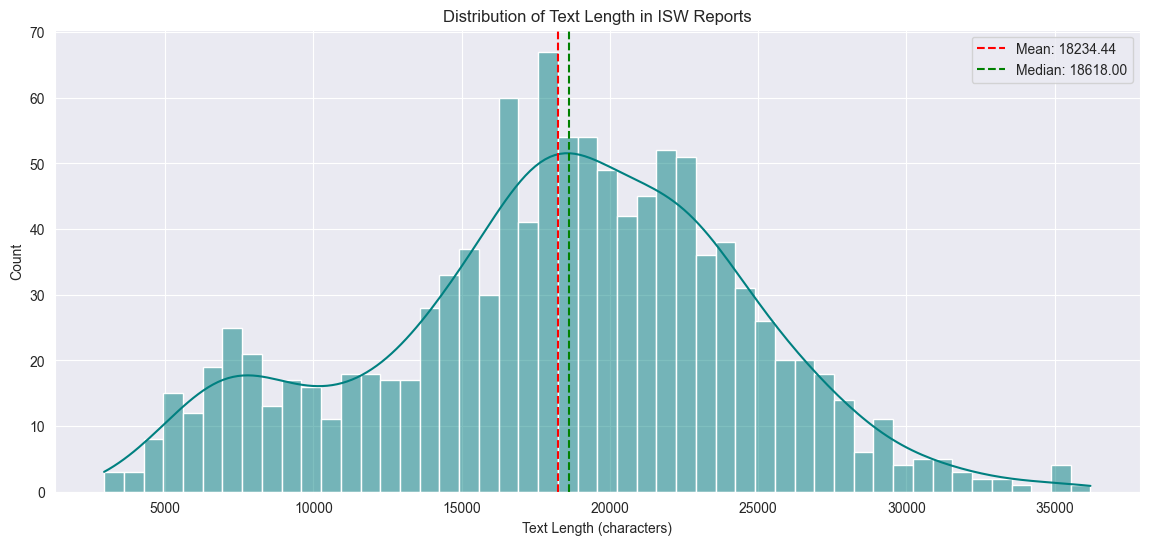

In [87]:
df_copy['text_length'] = df_copy['lemmatized_text'].apply(len)
plt.figure(figsize=(14, 6))
sns.histplot(df_copy['text_length'], bins=50, kde=True, color='teal')
plt.title('Distribution of Text Length in ISW Reports')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.axvline(df_copy['text_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_copy["text_length"].mean():.2f}')
plt.axvline(df_copy['text_length'].median(), color='green', linestyle='--',
            label=f'Median: {df_copy["text_length"].median():.2f}')
plt.legend();

Working with text:

In [88]:
df_copy['text_length'] = df_copy['lemmatized_text'].apply(len)
df_copy['word_count'] = df_copy['lemmatized_text'].apply(lambda x: len(str(x).split()))

# Text length statistics
print("\nText length statistics:")
print(f"Mean text length: {df_copy['text_length'].mean():.2f} characters")
print(f"Median text length: {df_copy['text_length'].median():.2f} characters")
print(f"Min text length: {df_copy['text_length'].min()} characters")
print(f"Max text length: {df_copy['text_length'].max()} characters")
print(f"Mean word count: {df_copy['word_count'].mean():.2f} words")
print(f"Median word count: {df_copy['word_count'].median():.2f} words")


Text length statistics:
Mean text length: 18234.44 characters
Median text length: 18618.00 characters
Min text length: 2937 characters
Max text length: 36212 characters
Mean word count: 2281.53 words
Median word count: 2324.00 words


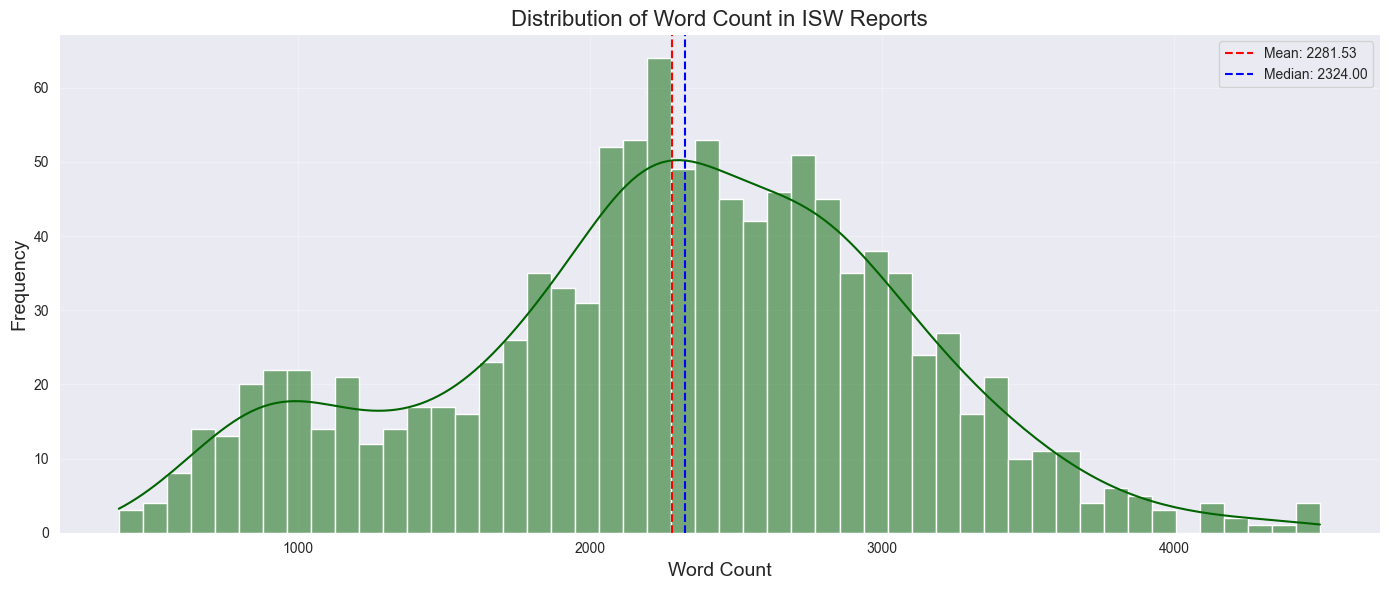

In [89]:
plt.figure(figsize=(14, 6))
sns.histplot(df_copy['word_count'], bins=50, kde=True, color='darkgreen')
plt.title('Distribution of Word Count in ISW Reports', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(df_copy['word_count'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_copy["word_count"].mean():.2f}')
plt.axvline(df_copy['word_count'].median(), color='blue', linestyle='--',
            label=f'Median: {df_copy["word_count"].median():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

because lack of reports in first months, we have problems in graphs:

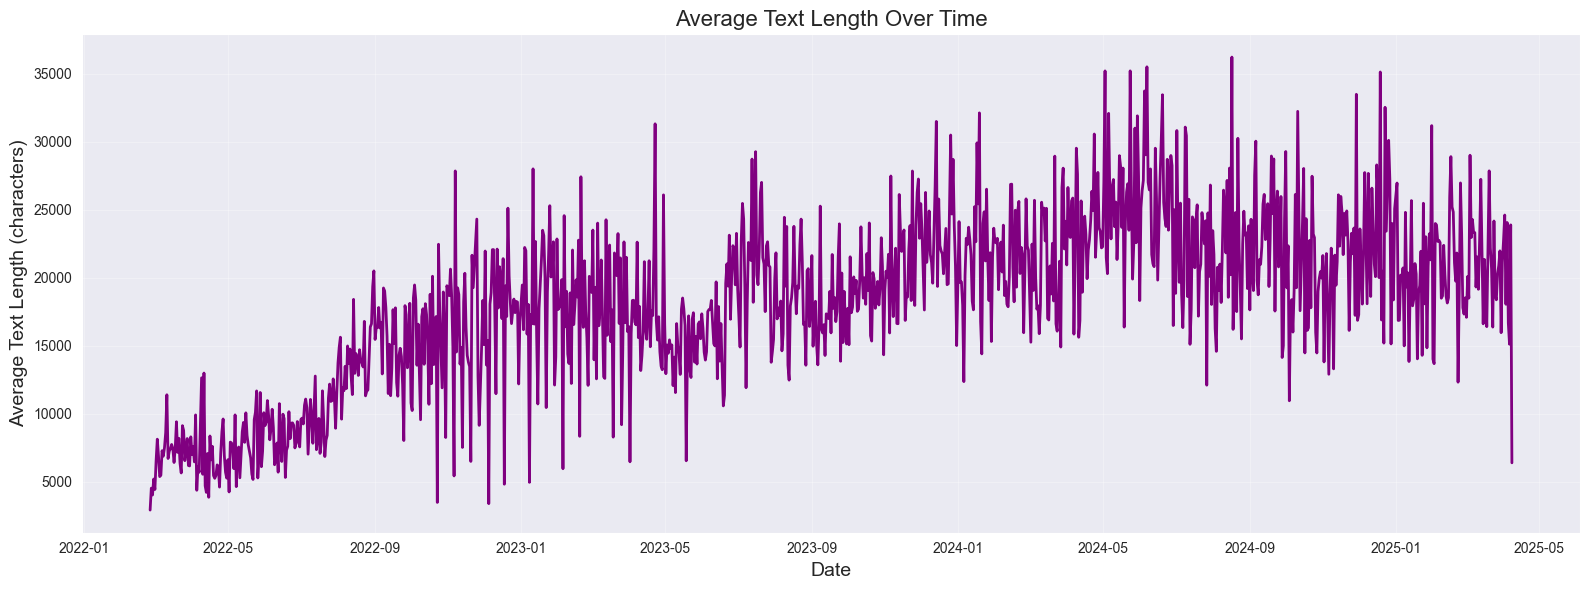

In [90]:
plt.figure(figsize=(16, 6))
text_length_by_date = df_copy.groupby(df_copy['date'].dt.date)['text_length'].mean()
text_length_by_date.plot(color='purple', linewidth=2)
plt.title('Average Text Length Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Text Length (characters)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('isw_text_length_over_time.png', dpi=300)
plt.show()

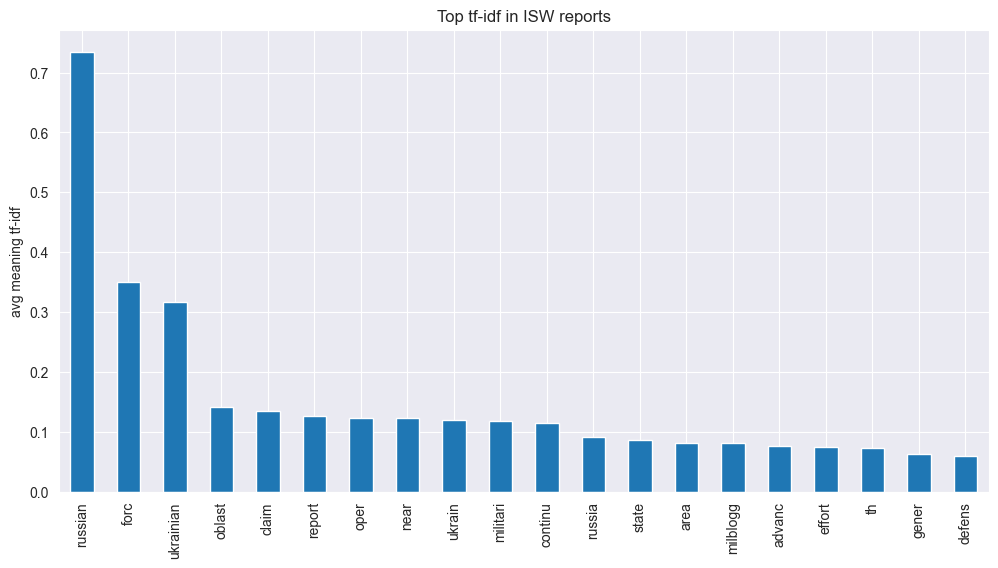

In [91]:
vectorizer = TfidfVectorizer(max_features=20)
X_tfidf = vectorizer.fit_transform(df_copy['stemmed_text'])
tfidf_scores = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_scores.mean().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Top tf-idf in ISW reports")
plt.ylabel("avg meaning tf-idf")
plt.show()


Once i do Tfidf vector, i relized that text not clean enough, so i deleted months and some words 

In [93]:
stop_words = set(stopwords.words('english'))

In [94]:
months = {
    'january', 'february', 'march', 'april', 'may', 'june',
    'july', 'august', 'september', 'october', 'november', 'december'
}

def clean_lemmed_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and word not in months]

    return ' '.join(tokens)

In [95]:
df['lem_text_clean'] = df['lemmatized_text'].apply(clean_lemmed_text)


In [96]:
df.head()

,_id,date,lemmatized_text,stemmed_text,lem_text_clean
0,67f568f9dcd7a5c401c30a6b,2022-02-25,russian force entered major ukrainian city inc...,russian forc enter major ukrainian citi includ...,russian force entered major ukrainian city inc...
1,67f568f9dcd7a5c401c30a6c,2022-02-26,russian force main ax advance last hour focuse...,russian forc main axe advanc last hour focus k...,russian force main advance last hour focused k...
2,67f568f9dcd7a5c401c30a6d,2022-02-27,russian military likely recognized initial exp...,russian militari like recogn initi expect limi...,russian military likely recognized initial exp...
3,67f568f9dcd7a5c401c30a6e,2022-02-28,russian military reorganizing military effort ...,russian militari reorgan militari effort attem...,russian military reorganizing military effort ...
4,67f568f9dcd7a5c401c30a6f,2022-03-01,russian force completing reinforcement resuppl...,russian forc complet reinforc resuppli troop n...,russian force completing reinforcement resuppl...


In [97]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=3,   #if word in <=3 docs      
    max_df=0.9, #words that used a lot      
)

In [98]:
X_tfidf = vectorizer.fit_transform(df['lem_text_clean'])

In [99]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf['date'] = df['date'].values

In [100]:
df_tfidf

,ability,able,access,accused,achieve,acknowledged,across,action,active,actor,...,yar,year,yet,yevgeny,york,youth,zaporizhzhia,zelensky,znpp,zone
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.040400,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.052553,0.0,...,0.000000,0.000000,0.129140,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.048976,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.052185,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.065141,0.034478,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.046576,0.0,0.000000,0.000000,0.042389,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,0.038432,0.027122,0.00000,0.000000,0.058150,0.0,0.000000,0.000000,0.000000,0.0,...,0.162275,0.000000,0.014450,0.0,0.0,0.00000,0.017458,0.000000,0.000000,0.016601
1119,0.020254,0.010720,0.01546,0.013091,0.000000,0.0,0.034047,0.010855,0.013945,0.0,...,0.093295,0.000000,0.011423,0.0,0.0,0.00000,0.027602,0.050814,0.000000,0.013124
1120,0.014538,0.000000,0.00000,0.000000,0.021997,0.0,0.000000,0.000000,0.000000,0.0,...,0.167417,0.015201,0.016398,0.0,0.0,0.00000,0.000000,0.091185,0.000000,0.018840
1121,0.029449,0.015587,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.067825,0.000000,0.016608,0.0,0.0,0.00000,0.000000,0.055412,0.000000,0.000000


it is great when sparsity <90%

In [101]:
nonzero = X_tfidf.nnz
total = X_tfidf.shape[0] * X_tfidf.shape[1]
sparsity = 1 - (nonzero / total)
print(f"Sparsity: {sparsity:.4f}")


Sparsity: 0.6082


default checking set, looks great 

In [102]:
word_sums = np.asarray(X_tfidf.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

word_df = pd.DataFrame({'word': words, 'tfidf_sum': word_sums})
word_df = word_df.sort_values(by='tfidf_sum', ascending=False)

print(word_df.head(20))

            word   tfidf_sum
85       bakhmut  107.213694
260        drone   94.297305
543   milblogger   89.497674
706        putin   81.841726
16      advanced   80.490060
272      element   77.721173
80      avdiivka   76.499875
839    southwest   69.303049
551          mod   67.214872
968       wagner   65.145969
544  milbloggers   64.484813
755        rifle   63.153235
115      brigade   62.781740
548      missile   62.616873
556    motorized   62.425092
606    operating   59.260159
719     recently   55.195896
465     kreminna   54.850701
595   occupation   54.376875
78     authority   53.830749
